In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression

# Functions for Fitting Gauss to Peaks of Pictures

In [110]:
#import the pictures
def read_images_in_folder(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[0])):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            images.append(plt.imread(image_path))
    return images

#import the pictures
def read_images_in_folder_short(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0])):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            images.append(plt.imread(image_path))
    return images


#returns the x_range of the peak
def get_range(x, pk):
    
    center = x[pk]
    
    left = center - 50
    right = center + 50
    
    if center < 49:
        left = 0
    if center > (1439-50):
        right = 1439
        
    x_range = np.arange(left, right)
        
    return x_range

#returns the number of the image of the peak
def image_of_peak(pk, n_pk):
    p = pk
    pic = -1
    while p >= 0:
        pic += 1
        p -= n_pk[pic]
    return pic

#returns at which place in the image the peak is
def peak_of_image(pk, n_pk):
    #number of peaks in total and per image
    poi = pk
    pic = image_of_peak(pk, n_pk)
    if pic == 0:
        return poi
    for i in range(pic):
        poi -= n_pk[i]
    return poi


#Define a Gaussian function
def gaussian(x, A, mu, sigma, background):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + background


def fit_gaussian(img, start_ind, end_ind):

    # Extract the subset of data for fitting
    x_data = np.arange(start_ind, end_ind)
    y_data = img[start_ind:end_ind]
        
    # Initial guess for the parameters [Amplitude, Mean, Standard Deviation]
    initial_guess = [np.max(y_data), start_ind+np.argmax(y_data), 10, 0.2]

    # Fit the Gaussian curve
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    return params


def plot_peak(avgs, i, x, n_pk, pk_params, la):
    peak = i
    pic = image_of_peak(peak, n_pk)
    A, mu, sigma, background = pk_params[peak]
    
    x_range = get_range(x, peak)
        
    start_index = x_range[0]
    end_index = x_range[-1]
    
    x_data = np.arange(start_index, end_index)
    y_data = avgs[pic][start_index:end_index]
    
    # Generate fitted curve
    x_fit = np.linspace(start_index, end_index, 1000)
    y_fit = gaussian(x_fit, A, mu, sigma, background)
    
    # Plot the data on the current axis
    ax.plot(x_data, y_data, label='Data')
    ax.plot(x_fit, y_fit, label='$\mu$={:.1f}, $\sigma$={:.2f}'.format(mu, sigma))
    ax.set_title('Picture {}, Peak {}, $\lambda$ = {:.1f}nm'.format(pic+1, peak_of_image(peak, n_peaks)+1, la[peak]))
    ax.legend()


def get_peak_params(x, avgs, peak, n_peaks):
    picture = avgs[image_of_peak(peak, n_peaks)]
    
    x_range = get_range(x, peak)
    start_index = x_range[0]
    end_index = x_range[-1]
    x_observed = x[peak]

    A, mu, sigma, background = fit_gaussian(picture, start_index, end_index)
    
    return np.array([A, mu, sigma, background])



In [111]:
#observations, x values are estimates for the center of the peaks

n_peaks = np.array([1,1,1,1,1])


cal_la = np.array([667.8,\
              587.6,\
              501.6,\
              447.1,\
              388.9])



cal_r = np.array([-64,\
             150,\
             380,\
             520,\
             670])

x_obs = np.array([410,\
                  490,\
                  646,\
                  606,\
                  561])


In [112]:
cal_peak_params = np.zeros((len(cal_la), 4), dtype=float)


cal_images = read_images_in_folder('./calibration/helium_lamp/')
cal_averages = np.mean(cal_images, axis = (1,3))

print(np.shape(cal_averages))

for peak in range(len(cal_la)):
    cal_peak_params[peak] = get_peak_params(x_obs, cal_averages, peak, n_peaks)    

(5, 1440)


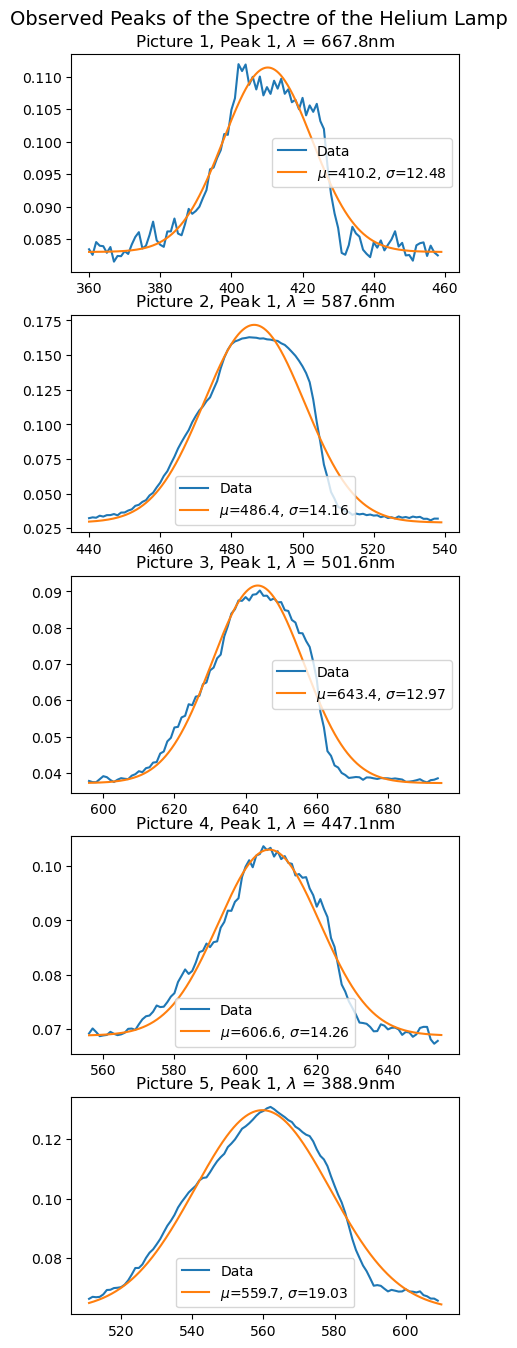

In [113]:
#plot everything
fig, axes = plt.subplots(len(cal_la),1, figsize=(5, 3*len(cal_la)))

# Loop through the axes and plot something on each one
for i, ax in enumerate(axes.flat):
    plot_peak(cal_averages, i, x_obs, n_peaks, cal_peak_params, cal_la)
    

# Adjust spacing between subplots for better layout
#plt.tight_layout()
plt.suptitle('Observed Peaks of the Spectre of the Helium Lamp', fontsize = 14)
plt.subplots_adjust(top=0.95)
#plt.savefig('helium.pdf', bbox_inches='tight')
plt.show()



In [114]:
#data analysis

x_gauss = cal_peak_params[:,1]


# Create a 2D array with the independent variables
X = np.column_stack((cal_r, x_gauss))

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, cal_la)

# Access the coefficients (slope) and intercept
coefficients = model.coef_
intercept = model.intercept_

a = coefficients[0]
b = coefficients[1]
c = intercept


#the spectrometer is now calibrated
def la_func(r,x):
    return a*r+ b*x + c


x_plt = x_obs+a/b*cal_r
x_fit = np.linspace(np.min(x_plt), np.max(x_plt),1000)

#plt.plot(x_plt, la, 'x')
#plt.plot(x_fit, b*x_fit+c)

print(a)
print(b)

-0.3837803209427792
0.01699002959244817


In [115]:
#3. computing g from p * dlambda = - dx * (g / f) cos(alpha_m)

s = 3.45e-6 #pixel length: cs165 cu / m
p = 1 # (order number)
alpha_m = 15/180*np.pi  #15° (angle of parabolic mirrors)
f = 0.381 #m (focal length)
#with dlambda/dx = b/s

g = p * f * b/s / np.cos(alpha_m)
print(g)
print(1e6/g) #gratings in one mm

1942.4785770204787
514.806192371952


# Spectrum Analysis

In [116]:
"""the knob position is the same for all measurements (except first led spectrum)"""

# knob positions of the pixels
r = np.array([-10, 30, 70, 110, 150, 190, 230, 270, 310, 350, 390, 430, 470, 510, 550])


images_wavelengths = np.zeros((len(r), 1440), dtype=float)

for i in range(len(r)):
    x = np.arange(0,1440,1)
    images_wavelengths[i,:] = la_func(r[i],x )
    
angles = np.linspace(0, 165, 12)
central_wavelengths = images_wavelengths[:,720]


In [117]:
"""read all the images"""

print('loading ...')

led_images = read_images_in_folder_short('./calibration/spectrum_only_water2')
led_images1 = read_images_in_folder_short('./calibration/spectrum_only_water')


sugar1_images_set = np.zeros((12,)+np.shape(led_images), dtype=float)
sugar4_images_set = np.zeros((12,)+np.shape(led_images), dtype=float)

for angle in range(0,180, 15):
    sugar1_images_set[int(angle/15)] = read_images_in_folder_short('./messungen/spectrum_0_1_saccharose/'+str(angle))
    sugar4_images_set[int(angle/15)] = read_images_in_folder_short('./messungen/spectrum_0_4_saccharose/'+str(angle))

    
led_images = np.array(led_images)[:,500:600,:]
led_images1 = np.array(led_images1)[:,500:600,:]


sugar1_images_set = np.array(sugar1_images_set)[:,:,500:600,:]
sugar4_images_set = np.array(sugar4_images_set)[:,:,500:600,:]


print('done')


print('size of led_images '+str(np.shape(led_images)))
print('size of sugari_images_set '+str(np.shape(sugar1_images_set)))

    

loading ...
done
size of led_images (15, 100, 1440, 3)
size of sugari_images_set (12, 15, 100, 1440, 3)


In [118]:
"""compute averages"""

print('loading ...')


# use only the pixel rows from 550 to 650
#led_images = np.array(led_images)[:,500:600,:]
led_averages = np.mean(led_images, axis = (1))
led_totavgs = np.mean(led_images, axis=(1,2,3))
led_averages1 = np.mean(led_images1, axis = (1))
led_totavgs1 = np.mean(led_images1, axis=(1,2,3))

#sugar1_averages_set = np.mean(sugar1_images_set, axis=(2))
#sugar4_averages_set = np.mean(sugar4_images_set, axis=(2))
sugar1_totavgs_set = np.mean(sugar1_images_set, axis=(2,3,4))
sugar4_totavgs_set = np.mean(sugar4_images_set, axis=(2,3,4))

print('done')


#print('size of led_averages '+str(np.shape(led_averages)))
#print('size of sugari_averages_set '+str(np.shape(sugar1_averages_set)))
print('size of led_totavgs '+str(np.shape(led_totavgs)))
print('size of sugari_totavgs_set '+str(np.shape(sugar1_totavgs_set)))


loading ...


done
size of led_totavgs (15,)
size of sugari_totavgs_set (12, 15)


In [119]:
"""smoothing"""

print('loading ...')


led_avgs_smooth = np.zeros(np.shape(led_averages), dtype=float)
led_avgs_smooth1 = np.zeros(np.shape(led_averages1), dtype=float)

#sugar1_avgs_smooth_set = np.zeros(np.shape(sugar1_averages_set), dtype=float)
#sugar4_avgs_smooth_set = np.zeros(np.shape(sugar4_averages_set), dtype=float)

led_totavgs_smooth = np.zeros(np.shape(led_totavgs), dtype=float)
sugar1_totavgs_smooth_set = np.zeros(np.shape(sugar1_totavgs_set), dtype=float)
sugar4_totavgs_smooth_set = np.zeros(np.shape(sugar4_totavgs_set), dtype=float)

window_size = 100
order = 1

for i in range(len(r)):
    for k in range(3):
        led_avgs_smooth[i,:,k] = savgol_filter(led_averages[i,:,k], window_size, order)
    #led_totavgs_smooth[i,:] = savgol_filter(led_totavgs[i,:], window_size, order)

    
#for j in range(len(angles)):
#    for i in range(len(r)):
#        for k in range(3):
#            sugar1_avgs_smooth_set[j,i,:,k] = savgol_filter(sugar1_averages_set[j,i,:,k], window_size, order)
#            sugar4_avgs_smooth_set[j,i,:,k] = savgol_filter(sugar4_averages_set[j,i,:,k], window_size, order)
        #sugar1_totavgs_smooth_set[j,i,:] = savgol_filter(sugar1_totavgs_set[j,i,:], window_size, order)
        #sugar4_totavgs_smooth_set[j,i,:] = savgol_filter(sugar4_totavgs_set[j,i,:], window_size, order)


print('done')


print('size of led_avgs_smooth '+str(np.shape(led_avgs_smooth)))
#print('size of sugari_avgs_smooth_set '+str(np.shape(sugar1_avgs_smooth_set)))
#print('size of led_totavgs_smooth '+str(np.shape(led_totavgs_smooth)))
#print('size of sugari_totavgs_smooth_set '+str(np.shape(sugar1_totavgs_smooth_set)))


loading ...
done
size of led_avgs_smooth (15, 1440, 3)


In [121]:
"""norm everything"""

print('loading ...')


#sugar1_normed_set = np.zeros(np.shape(sugar1_averages_set), dtype=float)
#sugar4_normed_set = np.zeros(np.shape(sugar1_averages_set), dtype=float)
sugar1_totnormed_set = np.zeros(np.shape(sugar1_totavgs_set), dtype=float)
sugar4_totnormed_set = np.zeros(np.shape(sugar1_totavgs_set), dtype=float)

for angle in range(0,180, 15):
    #sugar1_normed_set[int(angle/15)] = np.divide(sugar1_averages_set[int(angle/15)],led_averages)
    #sugar4_normed_set[int(angle/15)] = np.divide(sugar4_averages_set[int(angle/15)],led_averages)
    sugar1_totnormed_set[int(angle/15)] = np.divide(sugar1_totavgs_set[int(angle/15)],led_totavgs)
    sugar4_totnormed_set[int(angle/15)] = np.divide(sugar4_totavgs_set[int(angle/15)],led_totavgs)


print('done')


#print('size of sugari_normed_set '+str(np.shape(sugar1_normed_set)))
print('size of sugari_totnormed_set '+str(np.shape(sugar1_totnormed_set)))



loading ...
done
size of sugari_totnormed_set (12, 15)


In [122]:
print(np.shape(images_wavelengths))
print(np.shape(led_totavgs))
print(np.shape(sugar4_totavgs_set))
print(np.shape(sugar4_totnormed_set))

(15, 1440)
(15,)
(12, 15)
(12, 15)


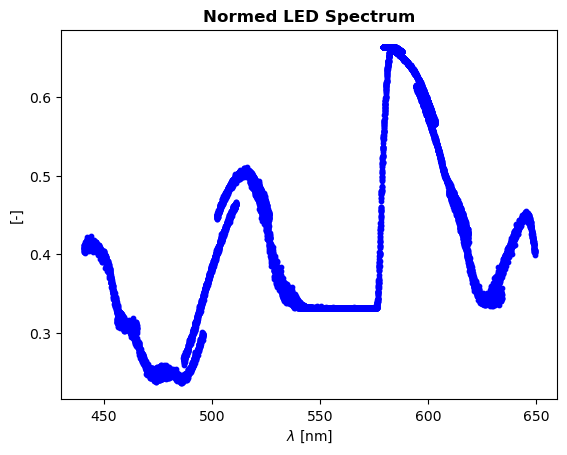

In [141]:
led = np.mean(led_averages, axis=2)
led1 = np.mean(led_avgs_smooth1, axis=2)

for i in range(len(r)-2, 0,-1):
    plt.scatter(images_wavelengths[i], led[i, :], color='blue', s=10)
    #plt.scatter(images_wavelengths[i], led1[i, :], color='red', s=10)


plt.title('Normed LED Spectrum', fontsize=12, fontweight='bold')
plt.ylabel('[-]')
plt.xlabel('$\lambda$ [nm]' )
plt.savefig('led_spectre.pdf',dpi=200)

In [124]:
sugar4 = np.roll(sugar4_totnormed_set,0)
angles4 = np.roll(angles,0)
sugar1 = np.roll(sugar1_totnormed_set,0)
angles1 = np.roll(angles,0)


print(angles1)
"""
fig, axs = plt.subplots(12, 2, figsize=(5, 25))

# Loop through each subplot

for wavelength in range(12):
    # Plot something on each subplot (for demonstration)
    axs[wavelength, 0].scatter(angles1, sugar1[:,wavelength])
    axs[wavelength, 0].set_title('$\lambda$ = '+str(np.round(central_wavelengths[wavelength]))+' nm')
    axs[wavelength, 0].set_xlabel('angle [grad]')
    axs[wavelength, 1].scatter(angles4, sugar4[:,wavelength])
    axs[wavelength, 1].set_title('$\lambda$ = '+str(np.round(central_wavelengths[wavelength]))+' nm')
    axs[wavelength, 1].set_xlabel('angle [grad]')

# Adjust layout to prevent overlapping
plt.suptitle('Intensity for 0.1g and 0.4g')
fig.tight_layout()

# Show the plot
fig.show()"""

[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165.]


"\nfig, axs = plt.subplots(12, 2, figsize=(5, 25))\n\n# Loop through each subplot\n\nfor wavelength in range(12):\n    # Plot something on each subplot (for demonstration)\n    axs[wavelength, 0].scatter(angles1, sugar1[:,wavelength])\n    axs[wavelength, 0].set_title('$\\lambda$ = '+str(np.round(central_wavelengths[wavelength]))+' nm')\n    axs[wavelength, 0].set_xlabel('angle [grad]')\n    axs[wavelength, 1].scatter(angles4, sugar4[:,wavelength])\n    axs[wavelength, 1].set_title('$\\lambda$ = '+str(np.round(central_wavelengths[wavelength]))+' nm')\n    axs[wavelength, 1].set_xlabel('angle [grad]')\n\n# Adjust layout to prevent overlapping\nplt.suptitle('Intensity for 0.1g and 0.4g')\nfig.tight_layout()\n\n# Show the plot\nfig.show()"

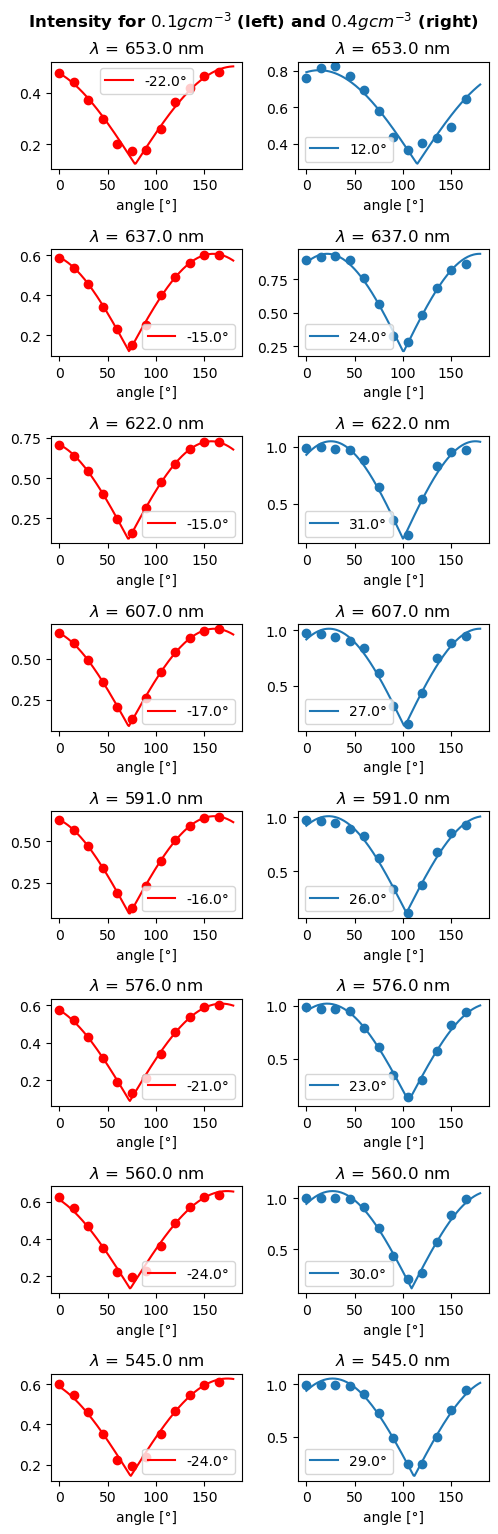

In [139]:
def cosfit(angle, parameters):
    omega, deltaphi, A, background = parameters
    return A*np.abs(np.cos(np.pi/180*(omega*angle -deltaphi)))+background

def model_wrapper(angle, omega, deltaphi, A, background):
    return cosfit(angle, [omega, deltaphi, A, background])

number_fitparams = 4
sugar1_fitparams = np.zeros((len(central_wavelengths), number_fitparams), dtype=float)
sugar4_fitparams = np.zeros((len(central_wavelengths), number_fitparams), dtype=float)


for wavelength in range(len(central_wavelengths)):
     # Initial guess for the parameters [Amplitude, Mean, Standard Deviation]
    
    bounds = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])


    # Fit the Gaussian curve
    initial_guess = [1, 0,1,0.1]
    params, covariance = curve_fit(model_wrapper, angles1, sugar1[:,wavelength], p0=initial_guess, bounds=bounds)
    sugar1_fitparams[wavelength] = params
    initial_guess = [1, 30,1,0.1]
    params, covariance = curve_fit(model_wrapper, angles4, sugar4[:,wavelength], p0=initial_guess, bounds=bounds)
    sugar4_fitparams[wavelength] = params



fit_angles = np.linspace(0,180, 181)
#fit_angles = np.linspace(-100,300, 181)

   
central_wavelengths_sliced = central_wavelengths[::2]
fig, axs = plt.subplots(len(central_wavelengths_sliced), 2, figsize=(5, 15))

# Loop through each subplot
for wavelength in range(len(central_wavelengths_sliced)):
    # Plot something on each subplot (for demonstration)
    axs[wavelength, 0].scatter(angles1, sugar1[:,wavelength],color='red')
    axs[wavelength, 0].plot(fit_angles, cosfit(fit_angles, sugar1_fitparams[wavelength]), color='red',label=str(np.round(sugar1_fitparams[wavelength,1]))+'°')
    axs[wavelength, 0].set_title('$\lambda$ = '+str(np.round(central_wavelengths[wavelength]))+' nm')
    axs[wavelength, 0].set_xlabel('angle [°]')
    axs[wavelength, 0].legend()
    axs[wavelength, 1].scatter(angles4, sugar4[:,wavelength])
    axs[wavelength, 1].plot(fit_angles, cosfit(fit_angles, sugar4_fitparams[wavelength]),label=str(np.round(sugar4_fitparams[wavelength,1]))+'°')
    axs[wavelength, 1].set_title('$\lambda$ = '+str(np.round(central_wavelengths[wavelength]))+' nm')
    axs[wavelength, 1].set_xlabel('angle [°]')
    axs[wavelength, 1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Adjust space at the top for the super title
plt.subplots_adjust(top=0.985)

# Add the super title
plt.suptitle('Intensity for $0.1gcm^{-3}$ (left) and $0.4gcm^{-3}$ (right)', y=1.02, fontsize=12, fontweight='bold')

# Save the plot
plt.savefig('plots.pdf', bbox_inches='tight', dpi=200)

# Show the plot
plt.show()


[1.02263529e+07 1.46557212e+03]


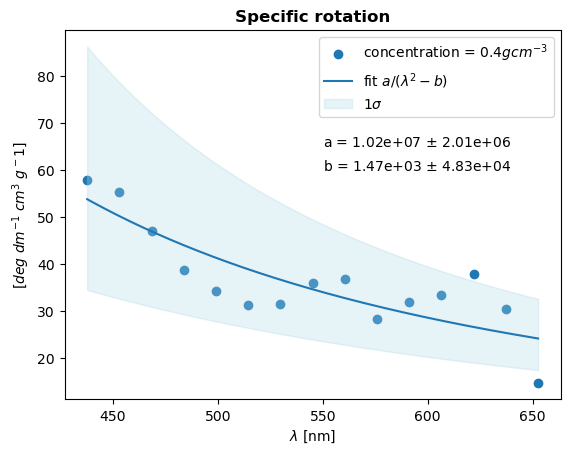

In [135]:
"""plotting and fitting the angle"""
l=2.02
torsionspec1 = -1*sugar1_fitparams[:,1]/(l*0.1)
torsionspec4 = sugar4_fitparams[:,1]/(l*0.4)
#print(central_wavelengths)


#def wldep(wavelength, a, b):
#    return a*wavelength+b
def wldep(wavelength, a, b,c):
    return a*np.exp(b*wavelength)+c

def wldep2(wavelength, a, b):
    return a/(wavelength**2-b)

#initial_guess = [-0.1,40]
initial_guess = [1000,-100,20]
initial_guess2 = [20,0.02]
params1, covariance1 = curve_fit(wldep2, central_wavelengths, torsionspec1, p0=initial_guess2)
params4, covariance4 = curve_fit(wldep2, central_wavelengths, torsionspec4, p0=initial_guess2)

x_fit = np.linspace(central_wavelengths[0], central_wavelengths[-1],1000)

perror= np.sqrt(np.diag(covariance4))
fit_upper=wldep2(x_fit,params4[0]+perror[0], params4[1]+perror[1])
fit_lower=wldep2(x_fit,params4[0]-perror[0], params4[1]-perror[1])

#plt.scatter(central_wavelengths, torsionspec1, label='concentration = $0.1gcm^{-3}$')
#plt.plot(x_fit,wldep(x_fit,params1[0], params1[1], params1[2]))
plt.scatter(central_wavelengths, torsionspec4, label='concentration = $0.4gcm^{-3}$')
plt.plot(x_fit,wldep2(x_fit,params4[0], params4[1]), label='fit $a/(\lambda^2-b)$')
plt.fill_between(x_fit, fit_lower, fit_upper, alpha=0.3, label='1$\sigma$', color='lightblue')
plt.title('Specific rotation', fontsize=12, fontweight='bold')
plt.ylabel('[$deg$ $dm^{-1}$ $cm^3$ $g^-1$]')
plt.xlabel('$\lambda$ [nm]' )
plt.text(550,65, 'a = {:.2e} $\pm$ {:.2e}'.format(params4[0], perror[0]))
plt.text(550,60, 'b = {:.2e} $\pm$ {:.2e}'.format(params4[1], perror[1]))
plt.legend()

plt.savefig('spec_rot.pdf', bbox_inches='tight', dpi=200)

#print(wldep(830, params1[0], params1[1]))
#print(wldep(830, params4[0], params4[1]))
print(params4)

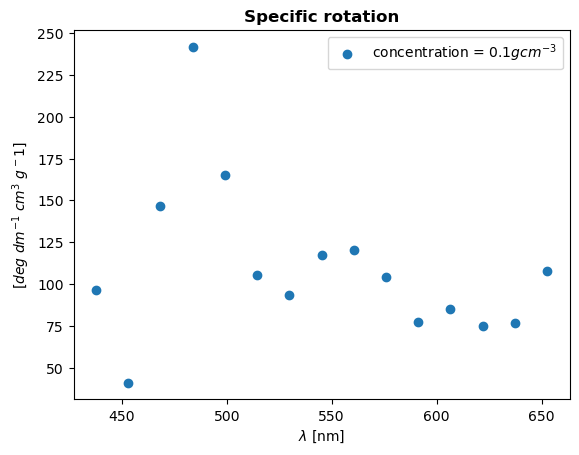

In [137]:
#perror= np.sqrt(np.diag(covariance1))
#fit_upper=wldep2(x_fit,params1[0]+perror[0], params1[1]+perror[1])
#fit_lower=wldep2(x_fit,params1[0]-perror[0], params1[1]-perror[1])
plt.scatter(central_wavelengths, torsionspec1, label='concentration = $0.1gcm^{-3}$')
#plt.plot(x_fit,wldep2(x_fit,params1[0], params1[1]), label='fit $a/(\lambda^2-b)$')
#plt.fill_between(x_fit, fit_lower, fit_upper, alpha=0.3, label='1$\sigma$', color='lightblue')

plt.title('Specific rotation', fontsize=12, fontweight='bold')
plt.ylabel('[$deg$ $dm^{-1}$ $cm^3$ $g^-1$]')
plt.xlabel('$\lambda$ [nm]' )
plt.legend()